# Convert timezone
***

**Autor:** Chus Casado Rodríguez<br>
**Date:** 21-05-2025<br>

**Introduction:**<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.auto import tqdm

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs import read_attributes
from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis, compare_flows
from lisfloodreservoirs.utils.timeseries import clean_storage, clean_inflow, time_encoding

In [2]:
from typing import Union
from timezonefinder import TimezoneFinder
import pytz
import matplotlib.pyplot as plt

## Configuration

In [ ]:
cfg = DatasetConfig('config_ResOpsUS_v21.yml')

print(f'Time series will be saved in {cfg.PATH_TS}')

## Data

### Attributes


In [ ]:
# import all tables of attributes
attributes = read_attributes(cfg.PATH_ATTRS)
print(f'{attributes.shape[0]} reservoirs in the attribute tables')

### Time series
#### Oberserved: ResOpsUS

In [ ]:
path_plots = cfg.PATH_TS / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
resops_ts = {}
for grand_id in tqdm(attributes.index[:5], desc='Reading observed time series'): # ID refers to GRanD

    # load timeseries
    file = cfg.PATH_OBS_TS / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, index_col='date')
    else:
        print(f"{file} doesn't exist")

    # remove duplicated index
    series = series[~series.index.duplicated(keep='first')]
    # trim to GloFAS long run period
    start, end = cfg.START, cfg.END
    series = series.loc[start:end,:]
    if series.empty:
        print(f'Reservoir {grand_id} has no observations in the time period from {start} to {end}')
        continue
    # ensure there aren't gaps in the index
    dates = pd.date_range(series.first_valid_index(), series.last_valid_index(), freq='D')
    series = series.reindex(dates)
    series.index.name = 'date'

    # remove negative values
    series[series < 0] = np.nan
    # clean storage time series
    series.storage = clean_storage(series.storage, w=7, error_thr=0.1)
    # clean inflow time series
    series.inflow = clean_inflow(
        series.inflow, 
        storage=series.storage if attributes.loc[grand_id, 'STORAGE'] == 1 else None, 
        outlfow=series.outflow if attributes.loc[grand_id, 'OUTFLOW'] == 1 else None, 
        grad_thr=1e4, 
        balance_thr=5, 
        int_method='linear'
    )
    # save in dictionary
    resops_ts[grand_id] = series

    # plot observed time series
    plot_resops(
        series.storage,
        series.elevation,
        series.inflow,
        series.outflow,
        attributes.loc[grand_id, ['CAP_MCM', 'CAP_GLWD']].values,
        title=grand_id,
        save=path_plots / f'{grand_id:04}_lineplot.jpg'
        )

print(f'{len(resops_ts)} reservoirs in ResOpsUS time series')

***

## dummy case

In [5]:
def water_balance(Vo: float, inflow: pd.Series, outflow: pd.Series) -> pd.Series:

    storage = (inflow.cumsum() - outflow.cumsum()).shift(1) * 24 * 3600 + Vo
    storage.iloc[0] = Vo
        
    return storage

In [11]:
def convert_to_UTC_reindex(lon: float, lat: float, series: pd.DataFrame) -> pd.DataFrame:
    """Takes a time series with no timezone definition, finds the timezone based on the
    coordinates of the location, and converts the datetime index to UTC
    """

    # find timezone
    tf = TimezoneFinder()
    timezone_name = tf.timezone_at(lng=lon, lat=lat)
    print(timezone_name)

    # define timezone
    ts_local = series.copy()
    if ts_local.index.tz is None:
        ts_local.index = ts_local.index.tz_localize(timezone_name)
    else:
        ts_local.index = ts_local.index.tz_convert(timezone_name)

    # convert to UTC with offset
    ts_utc = ts_local.copy()
    ts_utc.index = ts_utc.index.tz_convert('UTC')

    return ts_utc

In [100]:
# create dummy series the local timezone
dates = pd.date_range(start=datetime(2020, 3, 26), end=datetime(2020, 4, 2), freq='D')
inflow = pd.Series([100, 110, 120, 200, 180, 150, 130, 120], index=dates)
outflow = pd.Series([100, 100, 100, 150, 180, 180, 180, 150], index=dates)
storage = water_balance(4 * 1e6, inflow, outflow)
ts = pd.concat([inflow, outflow, storage], axis=1)
ts.index.name = 'time'
ts.columns = ['inflow', 'outflow', 'storage']

In [101]:
# # remove random values
# ts.loc[dates[3], 'inflow'] = np.nan

### `.reindex()`

In [102]:
def reindex_to_00UTC(series_utc: pd.DataFrame) -> pd.DataFrame:
    """
    """

    # offset
    offset = series_utc.index.hour.min()
    print(f'offset: {offset} h')
    
    # timestamps with offset UTC
    idx_offset = series_utc.index
    
    # timestamps at 00 UTC
    dates = series_utc.index.date
    if offset == 0:
        start, end = series_utc.index[0], series_utc.index[-1]
    if offset <=12:
        start = series_utc.index.min().floor('D')
        end = series_utc.index.max().floor('D')
    elif offset > 12:
        start = series_utc.index.min().ceil('D')
        end = series_utc.index.max().ceil('D')
    print(f'start date:\t{start}\nend date:\t{end}')
    idx_00 = pd.date_range(
        start=start,
        end=end,
        freq='D',
        tz='UTC',
        name=series_utc.index.name
        )
    
    # interpolate linearly the values at 00 UTC
    idx = idx_00.union(idx_offset)
    series_00utc = series_utc.reindex(idx).interpolate(
        'time', 
        limit=1, 
        limit_direction='both',
    ).loc[idx_00]

    return series_00utc

In [105]:
# California
lon = -121
lat = 37

# Australia
lon = 150
lat = -30

# # Madrid
# lon = -3.5
# lat = 40

# # London
# lon = 0
# lat = 51

# convert time series to UTC (with offset)
ts_utc = convert_to_UTC_reindex(lon, lat, ts)

# interpolate values to 00 UTC
ts_00utc = reindex_to_00UTC(ts_utc)

# compute storage by water balance
ts_00utc['storage_wb'] = water_balance(ts_00utc.storage.iloc[0], ts_00utc.inflow, ts_00utc.outflow)

ts_00utc

Australia/Sydney
offset: 13 h
start date:	2020-03-26 00:00:00+00:00
end date:	2020-04-02 00:00:00+00:00


,inflow,outflow,storage,storage_wb
time,,,,
2020-03-26 00:00:00+00:00,104.583333,100.000000,4000000.0,4000000.0
2020-03-27 00:00:00+00:00,114.583333,100.000000,4396000.0,4396000.0
2020-03-28 00:00:00+00:00,156.666667,122.916667,5656000.0,5656000.0
2020-03-29 00:00:00+00:00,190.833333,163.750000,8572000.0,8572000.0
2020-03-30 00:00:00+00:00,166.250000,180.000000,10912000.0,10912000.0
2020-03-31 00:00:00+00:00,140.833333,180.000000,9724000.0,9724000.0
2020-04-01 00:00:00+00:00,125.416667,166.250000,6340000.0,6340000.0
2020-04-02 00:00:00+00:00,120.000000,150.000000,4000000.0,2812000.0


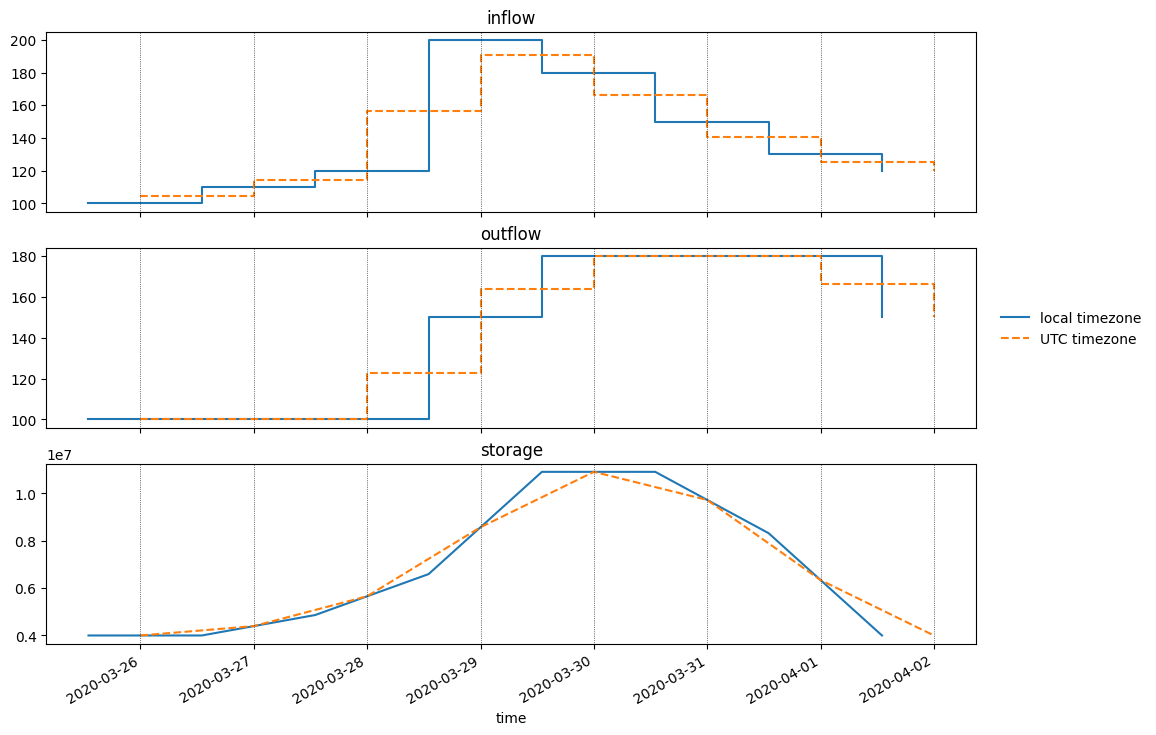

In [107]:
fig, axes = plt.subplots(figsize=(12, 9), nrows=3, sharex=True)
for ax, variable in zip(axes, ['inflow', 'outflow', 'storage']):
    drawstyle = 'steps-post' if variable in ['inflow', 'outflow'] else 'default'
    # original values 
    ts_utc[variable].plot(
        ax=ax, 
        label='local timezone', 
        drawstyle=drawstyle
    )
    # interpolated values
    ts_00utc[variable].plot(
        ax=ax, 
        ls='--',
        label='UTC timezone', 
        drawstyle=drawstyle
    )
    
    ax.set_title(variable)
    for date in np.unique(ts_00utc.index.date):
        ax.axvline(date, c='k', lw=.5, ls=':')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=6, bbox_to_anchor=[.91, .4, .1, .3]);

### `.resample()`

In [82]:
def resample_to_00UTC(series_utc: pd.DataFrame) -> pd.DataFrame:
    """
    """
    
    # offset
    offset = series_utc.index.hour.min()
    print(f'offset: {offset} h')
    
    # resample hourly values
    series_utc_hourly = series_utc.resample('h').interpolate(method='linear', limit=1)
    resample_to_00UTC.series_hourly = series_utc_hourly
    
    # compute daily means
    series_00utc_mean = series_utc_hourly.groupby(series_utc_hourly.index.date).mean()
    if offset != 0:
        if offset <= 12:
            series_00utc_mean.iloc[-1, :] = np.nan
        elif offset > 12:
            series_00utc_mean.iloc[0, :] = np.nan
    series_00utc_mean.index = pd.DatetimeIndex(series_00utc_mean.index, tz='UTC')
    
    # extract instant values at 00 UTC
    series_00utc_inst = series_utc_hourly[series_utc_hourly.index.hour == 0].copy()

    return series_00utc_mean, series_00utc_inst

<Axes: xlabel='time'>

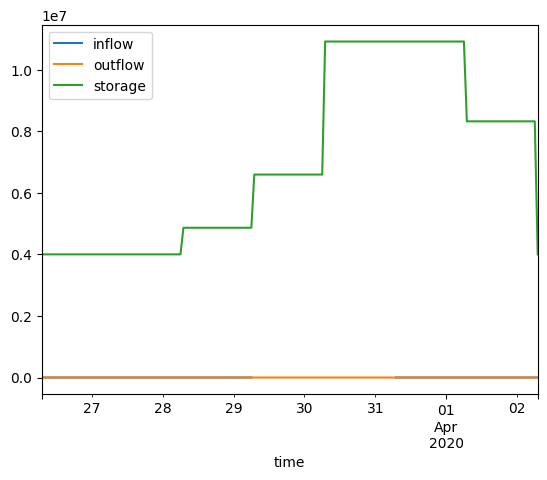

In [89]:
ts_utc.resample('h').ffill(limit=24).plot()

In [83]:
# interpolate values to 00 UTC
ts_00utc_mean, ts_00utc_inst = resample_to_00UTC(ts_utc)

# compute storage by water balance
ts_00utc_mean['storage_wb'] = water_balance(ts_00utc_mean.storage.iloc[0], ts_00utc_mean.inflow, ts_00utc_mean.outflow)
ts_00utc_inst['storage_wb'] = water_balance(ts_00utc_inst.storage.iloc[0], ts_00utc_inst.inflow, ts_00utc_inst.outflow)

# ts_00utc

offset: 7 h


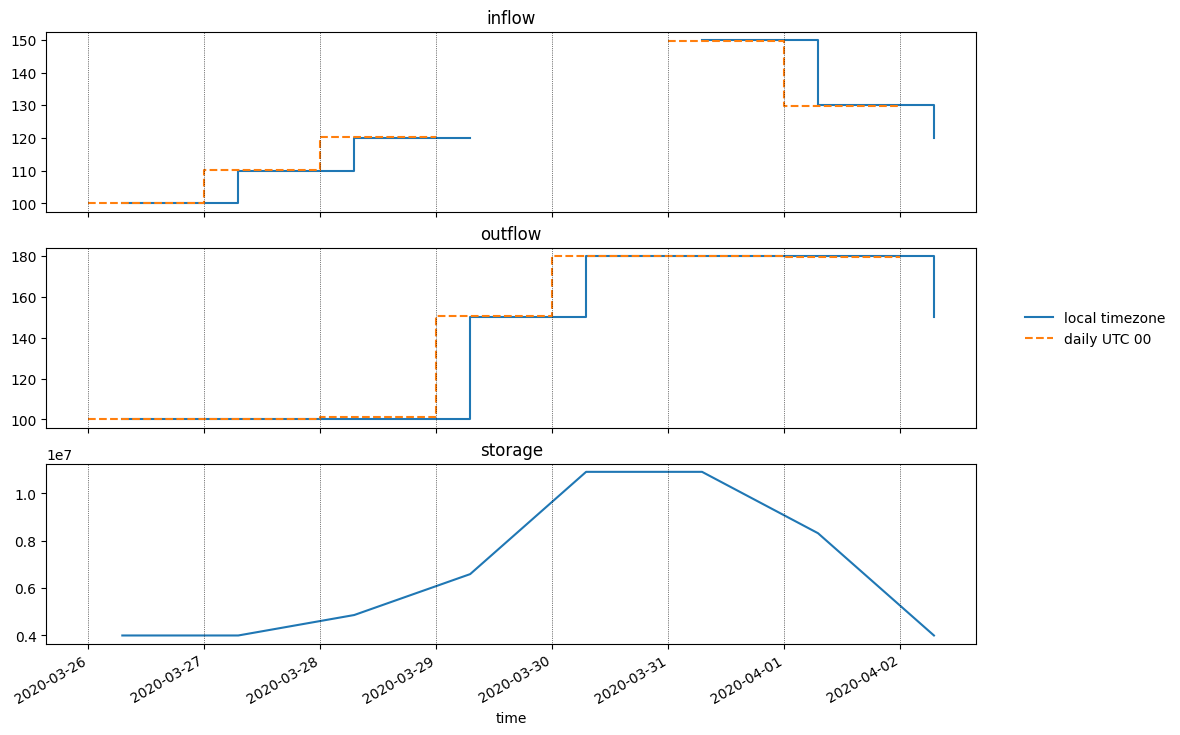

In [84]:
fig, axes = plt.subplots(figsize=(12, 9), nrows=3, sharex=True)
for ax, variable in zip(axes, ['inflow', 'outflow', 'storage']):
    drawstyle = 'steps-post' if variable in ['inflow', 'outflow'] else 'default'
    # original values 
    ts_utc[variable].plot(
        ax=ax, 
        label='local timezone', 
        drawstyle=drawstyle
    )
    # average daily values
    if variable in ['inflow', 'outflow']:
        ts_00utc_mean[variable].plot(
            ax=ax, 
            ls='--',
            label='daily mean (UTC)', 
            drawstyle='steps-post'
        )
    # instant values at UTC 00
    elif variable in ['storage']:
        ts_00utc_inst[variable].plot(
            ax=ax, 
            ls='--',
            label='daily UTC 00', 
            drawstyle='default'
        )
    
    ax.set_title(variable)
    for date in np.unique(ts_utc.index.date):
        ax.axvline(date, c='k', lw=.5, ls=':')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=6, bbox_to_anchor=[.93, .4, .1, .3]);

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(12, 9), nrows=3, sharex=True)

for ax, variable in zip(axes, ['inflow', 'outflow', 'storage']):
    ts_utc[variable].plot(ax=ax, label='original (daily)')
    ts_utc_hourly[variable].plot(ax=ax, ls='--', label='original (hourly)')
    ts_00utc_mean[variable].plot(ax=ax, label='daily UTC mean', drawstyle='steps-post')
    ax.scatter(ts_00utc_inst.index, ts_00utc_inst[variable], marker='x', color='C3', lw=1, label='daily UTC 00')
    
    ax.set_title(variable)
    for date in np.unique(ts_utc.index.date):
        ax.axvline(date, c='k', lw=.5, ls=':')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=6, bbox_to_anchor=[.93, .4, .1, .3]);

In [ ]:
ts_00utc_mean['storage_wb'] = water_balance(ts_00utc_mean.storage.iloc[0], ts_00utc_mean.inflow, ts_00utc_mean.outflow)

ts_00utc_mean

In [ ]:
ts_00utc_inst['storage_wb'] = water_balance(ts_00utc_inst.storage.iloc[0], ts_00utc_mean.inflow[1:], ts_00utc_mean.outflow[1:])

ts_00utc_inst

In [ ]:
# # recompute storage by water balance
# V = ts_00utc.storage.iloc[0]
# storage = [V]
# for I, O in zip(ts_00utc.inflow, ts_00utc.outflow):
#     V += (I - O) * pd.Timedelta(days=1).total_seconds()
#     storage.append(V)
# ts_00utc['storage_wb'] = storage[:-1]

# ts_00utc

In [ ]:
# # my formula using the area under the curve
# ts_00utc['storage_auc'] = np.nan
# storage = ts_utc.storage.values
# storage_auc = 1 / 1152 * (offset**2 * storage[:-2] + (24**2 + 48 * offset -2 * offset**2) * storage[1:-1] + (24 - offset)**2 * storage[2:])
# if offset <= 12:
#     ts_00utc['storage_auc'] = np.hstack(([storage[0]], storage_wb, [np.nan]))
# else:
#     ts_00utc['storage_auc'] = np.hstack((storage_wb, [storage[1], np.nan]))

# ts_00utc

In [ ]:
# # interpolate hourly values
# dates = ts_utc.index.date
# if offset == 0:
#     start, end = ts_utc.index[0], ts_utc.index[-1]
# elif offset < 12:
#     start = pd.Timestamp(dates[0], tz='UTC')
#     end = pd.Timestamp(dates[-2], tz='UTC') + pd.Timedelta(hours=23)
# elif offset > 12:
#     start = pd.Timestamp(dates[1], tz='UTC')
#     end = pd.Timestamp(dates[-1], tz='UTC') + pd.Timedelta(hours=23)

# print(start, end)

# # resample hourly values
# ts_utc_hourly = ts_utc.resample('h').interpolate(method='linear')
# ts_utc_hourly = ts_utc_hourly.loc[start:end]

In [ ]:
# hours = pd.date_range(start, end, freq='h', tz='UTC')
# aux = ts_utc.reindex(hours).interpolate('time')

# aux.tail(10)

In [ ]:
ts_00utc_mean

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ts_utc.storage.plot(ax=ax, label='daily offset')
ts_utc_hourly = ts_utc.storage.resample('h').interpolate(method='linear')
ts_utc_hourly.plot(ax=ax, label='hourly')
ts_utc_hourly.groupby(ts_utc_hourly.index.date).mean().plot(ax=ax, label='daily mean')
ts_utc_hourly[ts_utc_hourly.index.hour == 0].plot(ax=ax, label='daily inst')
for date in np.unique(ts_utc.index.date):
    ax.axvline(date, c='k', lw=.5, ls=':')
ax.legend();

In [ ]:
ts_utc_hourly[ts_utc_hourly.index.hour == 0]

In [ ]:
ts_utc.index

In [ ]:
storage_wb

In [ ]:
aux['avg'].iloc[1:]

In [ ]:
aux['result'].iloc[:-1]

In [ ]:
aux = pd.DataFrame(ts.storage)
aux.columns = ['day1']
offset = aux.index.hour.min()
print(offset)
if offset <= 12:
    aux['day2'] = aux.day1.shift(-1)
# else:
#     aux['day2'] = aux.day1.shift(1)
aux['avg'] = aux[['day1', 'day2']].mean(axis=1)
storage = 1 / 24 * (offset * aux['avg'].iloc[:-1].values + (24 - offset) * aux['avg'].iloc[1:].values)
aux['result'] = np.nan
if offset <= 12:
    aux['result'].iloc[:-1] = storage
else:
    aux['result'].iloc[1:] = storage
aux

In [ ]:
ts_00utc

In [ ]:
min([idx.hour for idx in aux.index])

In [ ]:
# rolling mean of width 2
V_ = np.mean([ts.storage.values[:-1], ts.storage.values[1:]], axis=0)
if offset <= 12:
    V_ = np.hstack([ts.storage.iloc[0], V_])
else:
    V_ = np.hstack([V_, ts.storage.iloc[-1]])

# weighted mean
V = (offset * V_[:-1] + (24 - offset) * V_[1:]) / 24
if offset <= 12:
    V = np.hstack([ts.storage.iloc[0], V])
else:
    V = np.hstack([V, ts.storage.iloc[-1]])

ts_00utc['storage4'] = V

In [ ]:
ts_00utc

In [ ]:
ts.storage.rolling(2, min_periods=1, center=False).mean()

In [ ]:
ts.storage.rolling(2, min_periods=1, center=True).mean()

In [ ]:
ts_00utc

In [ ]:
(ts_00utc[['inflow', 'outflow']].iloc[:-1] * 24 * 3600).sum().diff(-1)

In [ ]:
print('inflow - outflow  = {0} m3'.format((ts_00utc[['outflow', 'inflow']].iloc[:-1] * 24 * 3600).sum().diff().iloc[-1]))
print('change in storage = {0} m3'.format(ts_00utc.storage.iloc[-1] - ts_00utc.storage.iloc[0]))

In [ ]:
ts

In [ ]:
ts_00utc

In [ ]:
ts.inflow.sum(), ts_00utc.inflow.sum()

In [ ]:
ts.outflow.sum(), ts_00utc.outflow.sum()

In [ ]:
(ts_00utc[['inflow', 'outflow']].iloc[:-1] * 24 * 3600).sum().diff(), ts_00utc.storage.iloc[[0, -1]].diff().iloc[-1]

***

In [ ]:
from datetime import datetime
from timezonefinder import TimezoneFinder
# from zoneinfo import ZoneInfo
import pytz

In [ ]:
v1 = 2
v2 = 4
v3 = 3
x = 6

In [ ]:
V = 1 / (2 * 24**2) * (x**2 * v1 + (24**2 + 48 * x - x**2) * v2 + (24 - x)**2 * v3)
V

In [ ]:
v2_ = 1 

In [ ]:
V = 1 / 24 * (x * v1 + (24 - x) * v2) 
V

In [ ]:
1 / 48 * (x * v1 + 24 * v2 + (24-x) * v3)

In [ ]:
from typing import Union
from timezonefinder import TimezoneFinder
import pytz

def timeseries_to_utc(
    series: Union[pd.DataFrame, pd.Series], 
    longitude: float, 
    latitude: float
) -> Union[pd.DataFrame, pd.Series]:
    """
    Converts a pandas Series or DataFrame with a DatetimeIndex to UTC,
    localizing it first based on provided longitude and latitude, and then
    interpolating values to ensure a daily 00:00 UTC index.

    This function is useful for standardizing time series data from various
    local time zones to a common UTC reference, ensuring consistent daily
    observations aligned to midnight UTC.

    Parameters
    ----------
    series : pandas.DataFrame or pandas.Series
        The input time series data. Its index must be a DatetimeIndex.
        If the index is naive (timezone-unaware), it will be localized
        to the timezone determined by `longitude` and `latitude`. If it
        is already timezone-aware, it will be converted to the local
        timezone if it's different.
    longitude : float
        The longitude of the location for which the timezone is to be
        determined.
    latitude : float
        The latitude of the location for which the timezone is to be
        determined.

    Returns
    -------
    pandas.DataFrame or pandas.Series
        A new Series or DataFrame with its DatetimeIndex converted to UTC,
        aligned to 00:00 UTC for each day, and interpolated values.
        The data type will match the input `series` type.
    """

    # get the timezone object
    tf = TimezoneFinder()
    timezone_name = tf.timezone_at(lng=longitude, lat=latitude)
    if timezone_name is None:
        raise Exception(f"Could not determine timezone for longitude={longitude}, latitude={latitude}")
    local_tz = pytz.timezone(timezone_name)

    # define/convert original time series to the local timezone
    series_local = series.copy()
    if not isinstance(series_local.index, pd.DatetimeIndex):
        raise TypeError("The input series must have a DatetimeIndex.")
    if series_local.index.tz is None:
        series_local.index = series_local.index.tz_localize(local_tz)
    elif str(series_local.index.tz) != local_tz:
        series_local.index = series_local.index.tz_convert(local_tz)

    # convert to UTC (index will have an offset compared with 00 am)
    series_utc = series_local.copy()
    series_utc.index = series_utc.index.tz_convert('UTC')
    idx_offset = series_utc.index

    # interpolate to 00 am
    idx_00 = pd.date_range(
        start=series_utc.index.min().floor('D'),
        end=series_utc.index.max().ceil('D'),
        freq='D',
        tz='UTC',
        name=series_utc.index.name
        )
    idx = idx_00.union(idx_offset)
    series_00UTC = series_utc.reindex(idx).interpolate('time', limit=1, limit_direction='both').loc[idx_00]

    return series_00UTC

In [ ]:
ts = timeseries_to_utc(resops_ts[grand_id], *attributes.loc[grand_id, ['LON', 'LAT']])

In [ ]:
ts.storage.plot()

In [ ]:
lon, lat = 

In [ ]:
timezone_name = tf.timezone_at(lng=lon, lat=lat)
timezone_name

In [ ]:
local_tz = pytz.timezone(timezone_name)
local_tz

In [ ]:
df = resops_ts[grand_id]

In [ ]:
if df.index.tz is None:
    df = df.copy()
    df.index = df.index.tz_localize(local_tz)
elif str(df.index.tz) != local_tz:
    df = df.copy()
    df.index = df.index.tz_convert(local_tz)

In [ ]:
df.index.tz

In [ ]:
df.plot();

In [ ]:
df_utc = df.copy()
df_utc.index = df_utc.index.tz_convert('UTC')

In [ ]:
df.head()

In [ ]:
df_utc.head()

In [ ]:
idx_00 = pd.date_range(
    start=df_utc.index.min().floor('D'),
    end=df_utc.index.max().floor('D'),
    freq='D',
    tz='UTC',
    name=df_utc.index.name
)
idx_offset = df_utc.index

idx = idx_00.union(idx_offset)
foo = df_utc.reindex(idx).interpolate('time', limit=1, limit_direction='both').loc[idx_00]

In [ ]:
foo

In [ ]:
foo.tail()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_utc

In [ ]:
foo

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
df.storage.plot(ax=ax, label='local')
df_utc.storage.plot(ax=ax, label='UTC')
foo.storage.plot(ax=ax, label='int')
ax.set_xlim(datetime(2015, 3, 1), datetime(2015, 3, 5))
ax.set_ylim(5, 15)
ax.legend(frameon=False);

In [ ]:
foo.shape

In [ ]:
29.486 + (29.274 - 29.486) * 17 / 24

In [ ]:
foo.storage.iloc[10000:10020]

In [ ]:
foo.storage.iloc[10000:10100].plot()

In [ ]:
start, end = datetime(2015, 3, 1), datetime(2015, 4, 1)
pd.concat((df_utc.loc[start:end, 'storage'], foo.loc[start:end, 'storage']), axis=1)

In [ ]:
df_interpolated = df_utc.reindex(idx_utc)#.interpolate(method='time')

df_interpolated.plot()

In [ ]:
ts_local.index = ts_local.index.tz_localize(local_tz)

In [ ]:
ts_local.head()

In [ ]:
idx_utc = ts.index.tz_localize(pytz.UTC)

In [ ]:
ts_utc

In [ ]:
datetime.utcnow()

In [ ]:
utc_offset = get_utc_offset(lat, lon)

In [ ]:
# --- Example Usage ---

# Example 1: New York City
lat1, lon1 = 40.7128, -74.0060  # New York City
offset1 = get_utc_offset(lat1, lon1)
print(f"UTC offset for ({lat1}, {lon1}) (New York City): {offset1} hours")

# Example 2: Berlin, Germany
lat2, lon2 = 52.5200, 13.4050  # Berlin, Germany
offset2 = get_utc_offset(lat2, lon2)
print(f"UTC offset for ({lat2}, {lon2}) (Berlin): {offset2} hours")

# Example 3: Sydney, Australia
lat3, lon3 = -33.8688, 151.2093 # Sydney, Australia
offset3 = get_utc_offset(lat3, lon3)
print(f"UTC offset for ({lat3}, {lon3}) (Sydney): {offset3} hours")

# Example 4: A point in the ocean (no specific timezone)
lat4, lon4 = 0.0, 0.0
offset4 = get_utc_offset(lat4, lon4)
print(f"UTC offset for ({lat4}, {lon4}) (Equator, Prime Meridian): {offset4}")

In [ ]:
tf = TimezoneFinder()

In [ ]:
lat, lon = attributes.loc[grand_id, ['LAT', 'LON']]

In [ ]:
timezone_name = tf.timezone_at(lng=lon, lat=lat)
timezone_name

In [ ]:
tz = ZoneInfo(timezone_name)
tz

In [ ]:
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo # Standard library for Python 3.9+

# 1. Initialize TimezoneFinder
tf = TimezoneFinder()

# 2. Define your point and a specific datetime for the calculation
#    (The UTC offset can change due to Daylight Saving Time)
lat, lon = attributes.loc[grand_id, ['LAT', 'LON']]
# You need a specific point in time to determine the *current* UTC offset
# because of Daylight Saving Time. Let's use a specific date.
target_datetime = datetime(2025, 7, 15, 12, 0, 0) # July 15, 2025, 12 PM local time

# 3. Find the IANA timezone name
timezone_name = tf.timezone_at(lng=lon, lat=lat)

In [ ]:
if timezone_name:
    print(f"Timezone name for ({latitude}, {longitude}): {timezone_name}")

    try:

In [ ]:
        # 4. Create a ZoneInfo object from the timezone name
        tz = ZoneInfo(timezone_name)

In [ ]:
tz.utcoffset(datetime.today())

In [ ]:
dir(tz)

In [ ]:
        # 5. Localize the target_datetime to this timezone
        #    This is crucial to get the correct offset for that specific date/time
        localized_dt = tz.localize(target_datetime) # For pytz. For zoneinfo, use replace()

In [ ]:
        # For zoneinfo, the recommended way to associate a datetime with a timezone
        # and get offset-aware behavior is to use .replace(tzinfo=...) or astimezone().
        # Let's create a naive datetime in UTC and convert it to the target timezone
        # to ensure we get the correct offset for that point in time.

        # A common way to get the offset is to create a datetime object in the target timezone
        # and then look at its utcoffset().
        # Let's use the target_datetime but make it timezone-aware.
        # This approach correctly handles DST.
        dt_aware = datetime(
            target_datetime.year,
            target_datetime.month,
            target_datetime.day,
            target_datetime.hour,
            target_datetime.minute,
            target_datetime.second,
            tzinfo=tz
        )

        # 6. Get the UTC offset (as a timedelta object)
        utc_offset_timedelta = dt_aware.utcoffset()

        if utc_offset_timedelta is not None:
            # Convert timedelta to hours and minutes for better readability
            total_seconds = utc_offset_timedelta.total_seconds()
            hours = int(total_seconds // 3600)
            minutes = int((total_seconds % 3600) // 60)

            offset_sign = "+" if hours >= 0 else "-"
            print(f"UTC Offset for {target_datetime.strftime('%Y-%m-%d %H:%M:%S')} in {timezone_name}: UTC{offset_sign}{abs(hours):02d}:{abs(minutes):02d}")
        else:
            print("Could not determine UTC offset.")

    except Exception as e:
        print(f"Error processing timezone {timezone_name}: {e}")

else:
    print(f"Could not determine timezone for latitude {latitude}, longitude {longitude}")

print("\n--- Another Example (Berlin, during standard time) ---")
latitude_berlin = 52.5061
longitude_berlin = 13.358
target_datetime_berlin = datetime(2025, 1, 15, 12, 0, 0) # Jan 15, 2025 (standard time)

timezone_name_berlin = tf.timezone_at(lng=longitude_berlin, lat=latitude_berlin)

if timezone_name_berlin:
    print(f"Timezone name for ({latitude_berlin}, {longitude_berlin}): {timezone_name_berlin}")
    try:
        tz_berlin = ZoneInfo(timezone_name_berlin)
        dt_aware_berlin = datetime(
            target_datetime_berlin.year,
            target_datetime_berlin.month,
            target_datetime_berlin.day,
            target_datetime_berlin.hour,
            target_datetime_berlin.minute,
            target_datetime_berlin.second,
            tzinfo=tz_berlin
        )
        utc_offset_timedelta_berlin = dt_aware_berlin.utcoffset()

        if utc_offset_timedelta_berlin is not None:
            total_seconds = utc_offset_timedelta_berlin.total_seconds()
            hours = int(total_seconds // 3600)
            minutes = int((total_seconds % 3600) // 60)
            offset_sign = "+" if hours >= 0 else "-"
            print(f"UTC Offset for {target_datetime_berlin.strftime('%Y-%m-%d %H:%M:%S')} in {timezone_name_berlin}: UTC{offset_sign}{abs(hours):02d}:{abs(minutes):02d}")
        else:
            print("Could not determine UTC offset.")
    except Exception as e:
        print(f"Error processing timezone {timezone_name_berlin}: {e}")